In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [ ]:
class Vibration(nn.Module):
    def __init__(self):
        super(Vibration, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,1),
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
class Net:
    def __init__(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = Vibration().to(device)
        self.h = 0.01
        self.k = 0.1
        x = torch.arange(0, 16+self.h, self.h)
        t = torch.arange(0, 1+self.k, self.k)

        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2,-1).T
        self.X = self.X.to(device)
        self.X.requires_grad = True

        # Boundary and initial condition sampling
        bc1 = torch.stack(torch.meshgrid(torch.tensor([x[0]]), t)).reshape(2,-1).T  # x = 0
        bc2 = torch.stack(torch.meshgrid(torch.tensor([x[-1]]), t)).reshape(2,-1).T  # x = L
        ic1 = torch.stack(torch.meshgrid(x, torch.tensor([t[0]]))).reshape(2,-1).T  # t = 0

        self.X_train = torch.cat([bc1, bc2, ic1])
        self.X_train = self.X_train.to(device)

        # Target for boundary and initial conditions
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic1 = torch.sin(torch.pi*ic1[:,0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic1]).unsqueeze(1)
        self.y_train = self.y_train.to(device)

        self.adam = torch.optim.Adam(self.model.parameters())
        self.optimizer = torch.optim.LBFGS(self.model.parameters(), lr=0.001, max_iter=50000,
                                           max_eval=50000, history_size=50, tolerance_grad=1e-7,
                                           tolerance_change=1.0*np.finfo(float).eps, line_search_fn="strong_wolfe")

        self.criterion = nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        # Data loss (boundary and initial condition losses)
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)

        # PDE loss
        u = self.model(self.X)
        du_dX = torch.autograd.grad(u, self.X, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
        du_dx = du_dX[:, 0]
        du_dt = du_dX[:, 1]

        du_dXX = torch.autograd.grad(du_dX, self.X, grad_outputs=torch.ones_like(du_dX), create_graph=True, retain_graph=True)[0]
        du_dxx = du_dXX[:, 0]
        du_dtt = du_dXX[:, 1]

        du_dXXX = torch.autograd.grad(du_dXX, self.X, grad_outputs=torch.ones_like(du_dXX), create_graph=True, retain_graph=True)[0]
        du_dXXXX = torch.autograd.grad(du_dXXX, self.X, grad_outputs=torch.ones_like(du_dXXX), create_graph=True, retain_graph=True)[0]
        du_dxxxx = du_dXXXX[:, 0]


        # Boundary and initial condition losses
        loss_bc3 = self.criterion( du_dxx[torch.where(self.X[:, 0] == 0.0)[0]], torch.zeros_like(du_dxx[torch.where(self.X[:, 0] == 0)[0]]))
        loss_bc4 = self.criterion( du_dxx[torch.where(self.X[:, 0] == 16.0)[0]], torch.zeros_like(du_dxx[torch.where(self.X[:, 0] == 16)[0]]))
        loss_ic2 = self.criterion(du_dt[torch.where(self.X[:, 1] == 0.0)[0]], torch.zeros_like(du_dt[torch.where(self.X[:, 1] == 0)[0]]))
        tolerance = 1e-6  # Define a tolerance for comparisons

# Boundary conditions
        #boundary_indices_x0 = torch.where(torch.abs(self.X[:, 0]) < tolerance)[0]
        #boundary_indices_x1 = torch.where(torch.abs(self.X[:, 0] - 2) < tolerance)[0]  # Assuming boundary at x = 2

        #loss_bc3 = self.criterion(du_dxx[boundary_indices_x0], torch.zeros_like(du_dxx[boundary_indices_x0]))
        #loss_bc4 = self.criterion(du_dxx[boundary_indices_x1], torch.zeros_like(du_dxx[boundary_indices_x1]))

# Initial condition
        #initial_indices = torch.where(torch.abs(self.X[:, 1]) < tolerance)[0]
        #loss_ic2 = self.criterion(du_dt[initial_indices], torch.zeros_like(du_dt[initial_indices]))

        loss_pde = self.criterion((205.0) * du_dxxxx + (1)*(7.83* 0.12) * du_dtt,0.0*torch.ones_like(du_dxxxx))

        # Total loss
        loss = loss_data + loss_pde + loss_bc3 + loss_bc4 + loss_ic2
        loss.backward(retain_graph=True)

        if self.iter % 1000 == 0:
            print(self.iter, loss.item())
        self.iter += 1
        return loss

    def train(self):
        self.model.train()
        for i in range(65000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval(self):
        self.model.eval()


In [ ]:
net = Net()
net.train()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1000 0.23136165738105774
2000 0.14772209525108337
3000 0.04997832328081131
4000 0.014072246849536896
5000 0.06852760165929794
6000 0.003049694001674652
7000 0.0010845119832083583
8000 0.019458815455436707
9000 0.0010513018351048231
10000 0.0030493466183543205
11000 0.0013649696484208107
12000 0.004028888884931803
13000 0.0009968107333406806
14000 0.0014096572995185852
15000 0.0008213046821765602
16000 0.0006088447407819331
17000 0.0005517049576155841
18000 0.004861288703978062
19000 0.00046384925371967256
20000 0.0034654182381927967
21000 0.0001181062834803015
22000 0.0022177482023835182
23000 0.002004152862355113
24000 0.0005442277179099619
25000 0.00047308148350566626
26000 0.0010676897363737226
27000 0.0020602147560566664
28000 0.00026428845012560487
29000 0.00012499305012170225
30000 0.0005030333995819092
31000 0.00235535460524261
32000 0.0018200846388936043
33000 0.0034121647477149963
34000 0.001962635200470686
35000 0.0003191924188286066
36000 0.0011999310227110982
37000 0.000326

In [ ]:
net.model.eval()

Vibration(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
h = 0.01
k = 0.01
x = torch.arange(0,16+h,h)
t = torch.arange(0,1+k,k)

X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X = X.to(net.X.device)

In [ ]:
model = net.model
model.eval()
with torch.no_grad():
  y_pred = model(X)
  y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

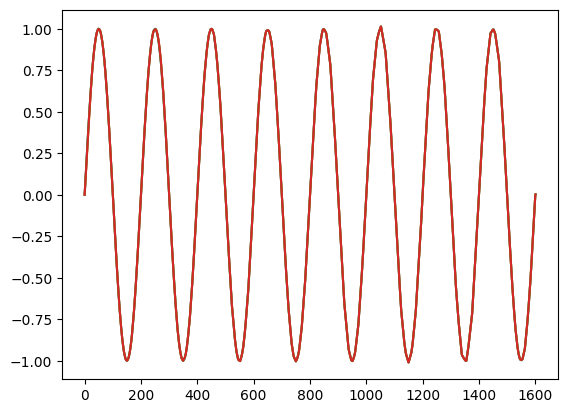

In [ ]:
plt.plot(y_pred[:,0])
plt.plot(y_pred[:,-1])
plt.plot(y_pred[:,50])
plt.plot(y_pred[:,90])

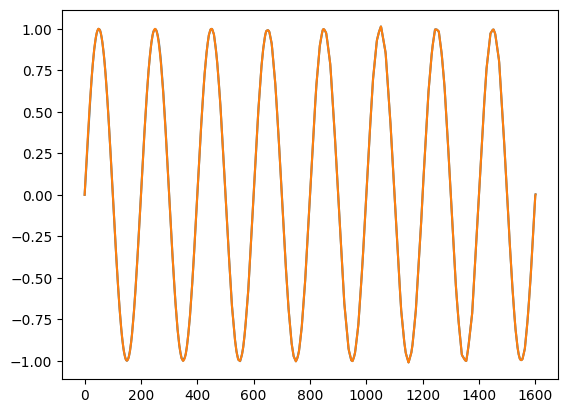

In [ ]:
plt.plot(y_pred[:,-1])
plt.plot(y_pred[:,0])


In [ ]:
class Net:
    def __init__(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = Vibration().to(device)
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(0, 1+self.h, self.h)
        t = torch.arange(0, 1+self.k, self.k)

        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2,-1).T
        self.X = self.X.to(device)
        self.X.requires_grad = True



        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2,-1).T
        ic1 = torch.stack(torch.meshgrid(x, t[0])).reshape(2,-1).T
        self.X_train = torch.cat([bc1, bc2,  ic1 ])
        self.X_train = self.X_train.to(device)

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))

        y_ic1 = torch.zeros(len(ic1))

        self.y_train = torch.cat([y_bc1, y_bc2,  y_ic1])
        self.y_train = self.y_train.to(device)

        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)

        self.adam = torch.optim.Adam(self.model.parameters())
        self.optimizer = torch.optim.LBFGS(self.model.parameters(),lr=0.001,max_iter=50000,max_eval=50000,history_size=50,tolerance_grad=1e-7,tolerance_change=1.0*np.finfo(float).eps,line_search_fn="strong_wolfe")

        self.criterion = nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred,self.y_train)


        u = self.model(self.X)
        du_dX = torch.autograd.grad(u, self.X, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]

        du_dx = du_dX[:,0]
        du_dt = du_dX[:,1]

        du_dXX = torch.autograd.grad(du_dX, self.X, grad_outputs=torch.ones_like(du_dX), create_graph=True, retain_graph=True)[0]
        du_dxx = du_dXX[:,0]
        du_dtt = du_dXX[:,1]

        du_dXXX = torch.autograd.grad(du_dXX, self.X, grad_outputs=torch.ones_like(du_dXX), create_graph=True, retain_graph=True)[0]
        du_dXXXX = torch.autograd.grad(du_dXXX, self.X, grad_outputs=torch.ones_like(du_dXXX), create_graph=True, retain_graph=True)[0]
        du_dxxxx = du_dXXXX[:,0]

        t_grid = self.X[:, 1]
        loss_bc3 = self.criterion((205)*du_dxx[torch.where(self.X[:, 0] == 0)[0]], torch.zeros_like(du_dxx[torch.where(self.X[:, 0] == 0)[0]]))  # d²u/dx²(0, t) = 0
        loss_bc4 = self.criterion((205)*du_dxx[torch.where(self.X[:, 0] == 1)[0]], torch.zeros_like(du_dxx[torch.where(self.X[:, 0] == 1)[0]]))  # d²u/dx²(1, t) = 0
        loss_ic2 = self.criterion(du_dt[torch.where(self.X[:, 1] == 0)[0]], torch.zeros_like(du_dt[torch.where(self.X[:, 1] == 0)[0]]))  # du/dt(x, 0) = 0
        load_indices = torch.where(torch.isclose(self.X[:, 0], torch.tensor(0.25)))[0]

        # Modify PDE loss to apply load only at x = 0.25
        # Create a tensor with zeros and the load value at the specified location
        load_values = torch.zeros_like(t_grid)
        load_values[load_indices] = 100 * torch.sin(100 * t_grid[load_indices])

        loss_pde = self.criterion((205)*du_dxxxx + (7830*0.012)*du_dtt, load_values)
        loss = loss_data + loss_pde + loss_bc3 + loss_bc4 + loss_ic2
        loss.backward(retain_graph=True)

        if self.iter % 1000 == 0:
          print(self.iter, loss.item())
        self.iter += 1
        return loss


    def train(self):

      self.model.train()
      for i in range(20000):
        self.adam.step(self.loss_func)
      self.optimizer.step(self.loss_func)

    def eval(self):
      self.model.eval()
